In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
from scipy.io import wavfile
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
from scipy.signal import cwt
from scipy.signal import hilbert
from scipy.signal import resample
from scipy.signal import decimate
from scipy.signal import spectrogram
from scipy.signal.windows import get_window
from scipy.stats import kurtosis
from scipy.integrate import simps

import librosa
import librosa.display
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import skimage.io
import cv2
import tensorflow as tf
import csv
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from shutil import copyfile, copy

from google.colab.patches import cv2_imshow

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
# implementation of diagnosis clasifier architecture

class DTLMC(tf.keras.Model):

  def __init__(self):
    super(DTLMC, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(3,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class DTLBC(tf.keras.Model):

  def __init__(self):
    super(DTLBC, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(2,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class SVM():

  def __init__(self):
    self.clf = sklearn.svm.SVC(kernel='linear')
    # other possible kernels include: "linear", "polynomial", "rbf", "sigmoid"

  def fit(X, y):
    self.clf.fit(X,y)

  def predict(X):
    return self.clf.predict(X)

In [25]:
#### helper functions for sound file handling
def print_plot_play(x, Fs, text=''):
    """1. Prints information about an audio singal, 2. plots the waveform, and 3. Creates player
    
    Notebook: C1/B_PythonAudio.ipynb
    
    Args: 
        x: Input signal
        Fs: Sampling rate of x    
        text: Text to print
    """
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(14, 5))
    plt.plot(x)
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

With the library 'librosa', we can easily handle audio files and create data arrays and spectograms out of the cough samples:

 Fs = 22050, x.shape = (216972,), x.dtype = float32


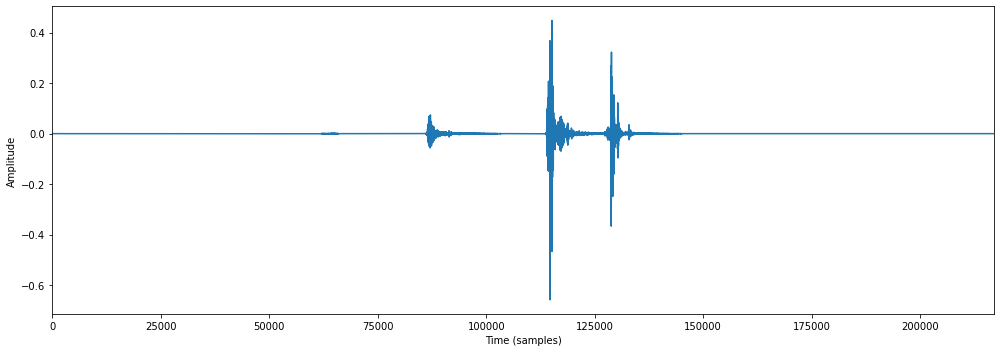

In [26]:
x , sr = librosa.load('./drive/MyDrive/COUGHVID/testcough.webm')
print_plot_play(x, sr)

We can't use any sound files that don't have a corresponding status attribute in their json file. Therefore we copy only those files that have a corresponding status attribute to another directory and call it the "clean" dataset. We will do all further work on this "clean" dataset.

In [ ]:
# cleans dataset by copying only files with status
# use with caution, takes a lot of time!!!


path = './drive/MyDrive/COUGHVID/public_dataset/'
destination = './drive/MyDrive/COUGHVID/public_dataset_cleaned/'

soundFileNames = []
for (dirpath, dirnames, filenames) in os.walk(path):
  for filename in filenames:
    if ".webm" in filename or ".ogg" in filename:
      soundFileNames.append(filename)



for fileName in soundFileNames:
  json_file_name = parseToJsonFilename(fileName)
  try:
    if hasStatusAttribute(path=path, fileName=json_file_name):
      copy(path + json_file_name, destination + json_file_name)
      copy(path + fileName, destination + fileName)
  except FileNotFoundError:
    print("file not found")
  


We create some helper functions to handle file extractions and spectogram image creation:

In [27]:

def load_json_from_drive(path,filename):
  with open(path + filename) as json_file:
    data = json.load(json_file)
  
  return data

def load_soundfile_from_drive(filename, path='./drive/MyDrive/COUGHVID/test_dset/'):
  x , sr = librosa.load(path + filename)
  return x, sr

def jsonFileNames(path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns the names of all .json files in the path as list of strings
    """
    jsonFileNames = []
    for (dirpath, dirnames, filenames) in os.walk(path):
      for filename in filenames:
        if ".json" in filename:
          jsonFileNames.append(filename)
    return jsonFileNames

def audioFileNames(path='./drive/MyDrive/COUGHVID/test_dset/'):
  """
  Returns the name of all .webm and .ogg files in the path as list of string
  """
  audioFileNames = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if ".webm" in filename or ".ogg" in filename:
        audioFileNames.append(filename)
  
  return audioFileNames

def hasStatusAttribute(fileName, path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns a boolean indicating if the specified json file has a 'status' key    
    """
    with open(path+fileName) as file:
        data = json.load(file)
        hasStatusAttribute = 'status' in data
        print('statusAttribute: ' + str(hasStatusAttribute))
        return hasStatusAttribute

def valueFromJsonParser(fileName, key, path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns the status of the specified json file 
    """    
    with open(os.path.join(path, fileName)) as file:
        data = json.load(file)
        return data[str(key)]

def generateMelSpectrogram(fileName, inputPath='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Generates Mel Spectogram from cough sample.
    Note: multiply values by -1 to avoid black images during png conversion
    """
    x, sr = load_soundfile_from_drive(fileName, inputPath)
    M = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128)
    M_db = librosa.power_to_db(M, ref=np.max) * -1
    dim = (320,240) # resize to dimensions from https://www.sciencedirect.com/science/article/pii/S2352914820303026
    resized = cv2.resize(M_db, dim, interpolation=cv2.INTER_LINEAR)

    return resized

def coughDetectionIsAboveThreshold(fileName, threshold, path='./drive/MyDrive/COUGHVID/test_dset/'):
    coughDetectionIsAboveThreshold = False
    if float(valueFromJsonParser(fileName,'cough_detected',path)) > threshold:
        coughDetectionIsAboveThreshold = True
    return coughDetectionIsAboveThreshold

def generateAllMelSpectrogramsAndLabelsFile(outputPath, threshold, nData, inputPath='./drive/MyDrive/COUGHVID/test_dset/'):
    LabelsList = []
    ThresholdList = []
    filenames = jsonFileNamesTest()
    if nData > 0:
      filenames = filenames[0:nData - 1]
    for filename in filenames:
      filename = filename.strip()
      try:
        if hasStatusAttribute(filename,inputPath) and coughDetectionIsAboveThreshold(filename, threshold, inputPath):
          LabelsList.append(valueFromJsonParser(filename,'status',inputPath))
          ThresholdList.append(valueFromJsonParser(filename,'cough_detected',inputPath))
          audioFileName = filename.strip(".json")+".webm"
          if os.path.isfile(inputPath + audioFileName) == False:
            audioFileName = filename.strip(".json")+".ogg"
          melSpectrogram = generateMelSpectrogramTest(audioFileName,inputPath)
          melSpectrogramFileName = filename.strip(".json")+".png"
          melSpectrogramFilePath = os.path.join(outputPath,melSpectrogramFileName)
          cv2.imwrite(melSpectrogramFilePath, melSpectrogram)
      except FileNotFoundError:
        print('File was not found')
        continue
    with open(os.path.join(outputPath,"LabelsAndThresholds.csv"), 'w') as file:
      wr = csv.writer(file)
      wr.writerow(LabelsList)
      wr.writerow(ThresholdList)

    
def readAllMelSpecs(path='./drive/MyDrive/COUGHVID/large_test_dset/'):
  data = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for file in filenames:
      if '.png' in file:
        filepath = path + file
        tmp = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        tmp_expanded=np.expand_dims(tmp,axis=1)
        data.append(tmp_expanded)

  return np.float32(np.array(data))

def oneHotEncoding(labels):
  oneHotList = []
  for label in labels:
    if label == 'healthy':
      oneHotList.append([1,0,0])
    elif label == 'symptomatic':
      oneHotList.append([0,0,1])
    elif label == 'COVID-19':
      oneHotList.append([0,1,0])

  return np.array(oneHotList)

def convertCSVToArrays(filepath = './drive/MyDrive/COUGHVID/test_dset/MelDiagrams/LabelsAndThresholds.csv'):

  labels = []
  coughValues = []

  with open(filepath, newline='') as csvfile:
      spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
      for index, row in enumerate(spamreader):
          entries = row[0].split(',')
          if index == 0:
            labels = entries
          else:
            coughValues = entries
  
  return np.array(labels), np.array(coughValues)

def parseToJsonFilename(filename):
  if ".webm" in filename:
    return filename.replace(".webm",".json")
  if ".ogg" in filename:
    return filename.replace(".ogg",".json")

Furthermore, the COUGHVID dataset provides some functions to work upon the data. We use the predefined feature classes and the segment_cough function.

In [8]:
# TODO: extract to another file and import it as a function

def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

def compute_SNR(x, fs):
    """Compute the Signal-to-Noise ratio of the audio signal x (np.array) with sampling frequency fs (float)"""
    segments, cough_mask = segment_cough(x,fs)
    RMS_signal = 0 if len(x[cough_mask])==0 else np.sqrt(np.mean(np.square(x[cough_mask])))
    RMS_noise = np.sqrt(np.mean(np.square(x[~cough_mask])))
    SNR = 0 if (RMS_signal==0 or np.isnan(RMS_noise)) else 20*np.log10(RMS_signal/RMS_noise)
    return SNR

In [9]:
# TODO: extract into extra file and import class
### feature classes from coughvid dataset
class features:
    # output should be  a np.array 
    # names should be a list of the size of output
    # add the number of features in output of each function
    n_std_dev = 1
    n_dummy = 2
    n_EEPD = 19
    n_PRE = 1
    n_ZCR = 1
    n_RMSP = 1
    n_DF = 1
    n_spectral_features = 6
    n_SF_SSTD = 2
    n_MFCC = 26
    n_CF = 1
    n_LGTH = 1
    n_SSL_SD = 2
    
    def __init__(self, FREQ_CUTS):
        self.FREQ_CUTS = FREQ_CUTS # list of Frequency Bands for the PSD
        self.n_PSD = len(FREQ_CUTS)
        
    def std_dev(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['std_dev'] # list of output features  
        std_deviation = np.ones((1,1))*np.std(data[1])
        return std_deviation, names
    
    def dummy(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature (MUST BE AN ARRAY)
        names = ['dummy_feature_2','dummy_3']
        return np.array([1.,2.]), names
    
    def fft(self,data):
        """
        Compute the spectrum using FFT
        """
        fs, cough = data
        fftdata = np.fft.rfft(cough)
        return fftdata
    
    # Envelope Energy Peak Detection
    def EEPD(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = []
        fs,cough = data
        fNyq = fs/2
        nPeaks = []
        freq_step = 50
        for fcl in range(50,1000,freq_step):
            names = names + ['EEPD'+str(fcl)+'_'+str(fcl+freq_step)]
            fc = [fcl/fNyq, (fcl+50)/fNyq]
            b, a = butter(1, fc, btype='bandpass')
            bpFilt = filtfilt(b, a, cough)
            b,a = butter(2, 10/fNyq, btype='lowpass')
            eed = filtfilt(b, a, bpFilt**2)
            eed = eed/np.max(eed+1e-17)
            peaks,_ = signal.find_peaks(eed)
            nPeaks.append(peaks.shape[0])
        return np.array(nPeaks), names

    # Phase Power Ratio Estimation
    def PRE(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['Power_Ratio_Est']
        fs,cough = data
        phaseLen = int(cough.shape[0]//3)
        P1 = cough[:phaseLen]
        P2 = cough[phaseLen:2*phaseLen]
        P3 = cough[2*phaseLen:]
        f = np.fft.fftfreq(phaseLen, 1/fs)
        P1 = np.abs(np.fft.fft(P1)[:phaseLen])
        P2 = np.abs(np.fft.fft(P2)[:phaseLen])
        P3 = np.abs(np.fft.fft(P3)[:phaseLen])
        P2norm = P2/(np.sum(P1)+1e-17)
        fBin = fs/(2*phaseLen +1e-17)
        f750,f1k,f2k5 = int(-(-750//fBin)), int(-(-1000//fBin)), int(-(-2500//fBin))
        ratio =  np.sum(P2norm[f1k:f2k5]) / np.sum(P2norm[:f750])
        return np.ones((1,1))*ratio, names
    
    # Zero Crossing Rate
    def ZCR(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['Zero_Crossing_Rate']
        fs,cough = data
        ZCR = (np.sum(np.multiply(cough[0:-1],cough[1:])<0)/(len(cough)-1))
        return np.ones((1,1))*ZCR, names
    
    # RMS Power
    def RMSP(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['RMS_Power']
        fs,cough = data
        RMS = np.sqrt(np.mean(np.square(cough)))
        return np.ones((1,1))*RMS, names
    
    # Dominant Frequency
    def DF(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['Dominant_Freq']
        fs,cough = data
        cough_fortan = np.asfortranarray(cough)
        freqs, psd = signal.welch(cough_fortan)
        DF = freqs[np.argmax(psd)]
        return  np.ones((1,1))*DF, names
    
    def spectral_features(self, data):
        names = ["Spectral_Centroid","Spectral_Rolloff","Spectral_Spread","Spectral_Skewness","Spectral_Kurtosis","Spectral_Bandwidth"]
        fs, x = data
        magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
        length = len(x)
        freqs = np.abs(np.fft.fftfreq(length, 1.0/fs)[:length//2+1]) # positive frequencies
        sum_mag = np.sum(magnitudes)
        
        # spectral centroid = weighted mean of frequencies wrt FFT value at each frequency
        spec_centroid = np.sum(magnitudes*freqs) / sum_mag

        #spectral roloff = frequency below which 95% of signal energy lies
        cumsum_mag = np.cumsum(magnitudes)
        spec_rolloff = np.min(np.where(cumsum_mag >= 0.95*sum_mag)[0]) 

        #spectral spread = weighted standard deviation of frequencies wrt FFT value
        spec_spread = np.sqrt(np.sum(((freqs-spec_centroid)**2)*magnitudes) / sum_mag)

        #spectral skewness = distribution of the spectrum around its mean
        spec_skewness = np.sum(((freqs-spec_centroid)**3)*magnitudes) / ((spec_spread**3)*sum_mag)

        #spectral kurtosis = flatness of spectrum around its mean
        spec_kurtosis =  np.sum(((freqs-spec_centroid)**4)*magnitudes) / ((spec_spread**4)*sum_mag)

        #spectral bandwidth = weighted spectral standard deviation
        p=2
        spec_bandwidth = (np.sum(magnitudes*(freqs-spec_centroid)**p))**(1/p)

        return np.array([spec_centroid, spec_rolloff, spec_spread, spec_skewness, spec_kurtosis, spec_bandwidth]), names
    
    # Spectral Flatness and spectral standard deviation
    def SF_SSTD(self, data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of the feature
        names = ['Spectral_Flatness', 'Spectral_StDev']
        fs,sig = data
        nperseg = min(900,len(sig))
        noverlap = min(600,int(nperseg/2))
        freqs, psd = signal.welch(sig, fs, nperseg=nperseg, noverlap=noverlap)
        psd_len = len(psd)
        gmean = np.exp((1/psd_len)*np.sum(np.log(psd + 1e-17)))
        amean = (1/psd_len)*np.sum(psd)
        SF = gmean/amean
        SSTD = np.std(psd)
        return np.array([SF, SSTD]), names
        
    #Spectral Slope and Spectral Decrease
    def SSL_SD(self,data):
        names=['Spectral_Slope','Spectral_Decrease']
        b1=0
        b2=8000
        
        Fs, x = data
        s = np.absolute(np.fft.fft(x))
        s = s[:s.shape[0]//2]
        muS = np.mean(s)
        f = np.linspace(0,Fs/2,s.shape[0])
        muF = np.mean(f)

        bidx = np.where(np.logical_and(b1 <= f, f <= b2))
        slope = np.sum(((f-muF)*(s-muS))[bidx]) / np.sum((f[bidx]-muF)**2)

        k = bidx[0][1:]
        sb1 = s[bidx[0][0]]
        decrease = np.sum((s[k]-sb1)/(f[k]-1+1e-17)) / (np.sum(s[k]) + 1e-17)

        return np.array([slope, decrease]), names
    
    #MFCC
    def MFCC(self,data):
        # data: wav file of segment; fs, signal = wavfile.read(file)
        # output: value of MFCC coefficient
        names = []; names_mean = []; names_std = []
        fs, cough = data
        n_mfcc = 13
        for i in range(n_mfcc):
            names_mean = names_mean + ['MFCC_mean'+str(i)]
            names_std = names_std +  ['MFCC_std'+str(i)]
        names = names_mean + names_std
        mfcc = librosa.feature.mfcc(y = cough, sr = fs, n_mfcc = n_mfcc)
        mfcc_mean = mfcc.mean(axis=1)
        mfcc_std = mfcc.std(axis=1)
        mfcc = np.append(mfcc_mean,mfcc_std)
        return mfcc, names
    
    # Crest Factor
    def CF(self,data):
        """
        Compute the crest factor of the signal
        """
        fs, cough = data
        peak = np.amax(np.absolute(cough))
        RMS = np.sqrt(np.mean(np.square(cough)))
        return np.ones((1,1))*peak/RMS, ['Crest_Factor']
    
    def LGTH(self,data):
        "Compute the length of the segment in seconds"
        fs, cough = data
        return np.ones((1,1))*(len(cough)/fs), ['Cough_Length']
    
    # Power spectral Density 
    def PSD(self,data):
        feat = []
        fs,sig = data
        nperseg = min(900,len(sig))
        noverlap=min(600,int(nperseg/2))
        freqs, psd = signal.welch(sig, fs, nperseg=nperseg, noverlap=noverlap)
        dx_freq = freqs[1]-freqs[0]
        total_power = simps(psd, dx=dx_freq)
        for lf, hf in self.FREQ_CUTS:
            idx_band = np.logical_and(freqs >= lf, freqs <= hf)
            band_power = simps(psd[idx_band], dx=dx_freq)
            feat.append(band_power/total_power)
        feat = np.array(feat)
        feat_names = [f'PSD_{lf}-{hf}' for lf, hf in self.FREQ_CUTS]
        return feat, feat_names

Working with the segment cough function, we can easily extract single coughs out of large samples as it is shown in the code below.

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


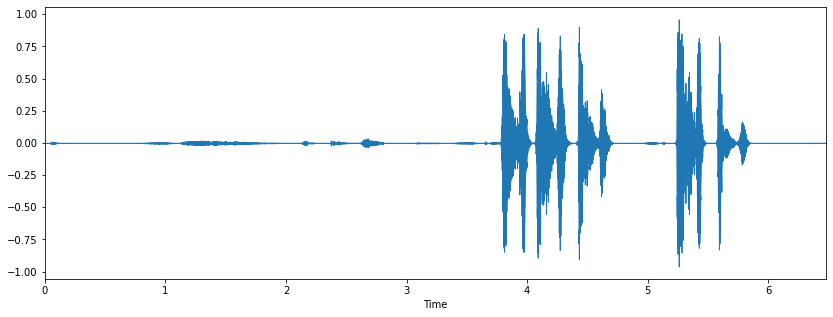

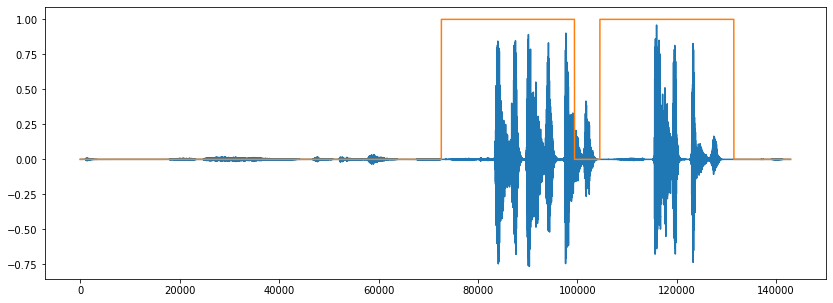

In [13]:
files = jsonFileNames()
x, sr = load_soundfile_from_drive(files[7].strip('.json') + '.webm')
plt.figure(figsize=(14,5))
librosa.display.waveplot(x)
x_new = librosa.stft(x)
x_db = librosa.amplitude_to_db(abs(x_new))

segments, cough_mask = segment_cough(x, sr, cough_padding=0.5)

plt.figure(figsize=(14,5))
#librosa.display.specshow(x_db, sr=sr)
plt.plot(x)
plt.plot(cough_mask)

We can than use this single coughs and pad them into a uniform length.

In [ ]:
### helper functions for segmentation
def padSingleCough(single_sample, sampling_rate):
  padded = np.pad(single_sample, int((3*sr-single_sample.shape[0])/2))
  if padded.shape[0] == 66150:
   # print("dropping last element")
    padded = padded[:-1]
  if padded.shape[0] == 66148:
    #print("appending one element")
    padded = np.append(padded, 0)
  return padded

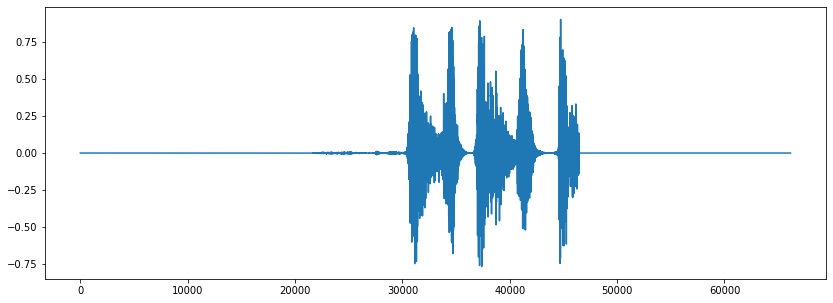

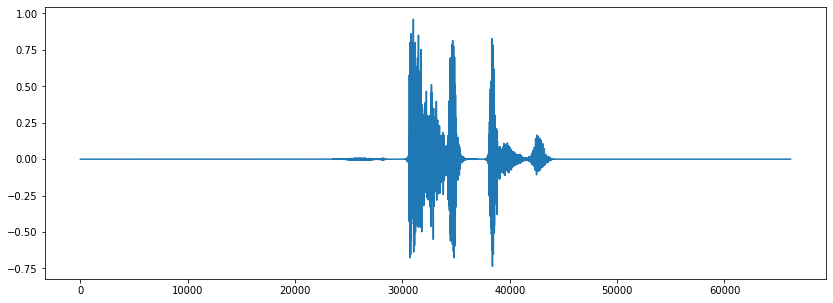

In [18]:

padded = padSingleCough(segments[0], sr)
padded_two = padSingleCough(segments[1], sr)

plt.figure(figsize=(14,5))
plt.plot(padded)

plt.figure(figsize=(14,5))
plt.plot(padded_two)

In [10]:
### Helper function to segment entire data
def createPaddedSamples(complete_sample, sampling_rate):
  padded_samples = np.array([]).reshape((0,66149))
  coughSegments, cough_mask = segment_cough(complete_sample, sampling_rate, cough_padding=0.4)
  amount = len(coughSegments)
  # drop sample if it is not segmentable
  if amount > 0:
    for segment in coughSegments:
      padded_sample = padSingleCough(segment, sampling_rate)
      padded_samples = np.vstack((padded_samples, padded_sample))

    return padded_samples, amount
  else:
    return None, None


def decomposeIntoSingleSamples(path):
  decomposed_samples = np.array([]).reshape((0,66149))
  labels = np.array([])
  cough_values = np.array([])
  filenames = audioFileNames(path)
  for filename in filenames[:1000]:
    complete_sample, sampling_rate = load_soundfile_from_drive(filename, path)
    padded_samples, amount = createPaddedSamples(complete_sample, sampling_rate)
    if padded_samples is not None:
      decomposed_samples = np.vstack((decomposed_samples, padded_samples))
      jsonFileName = parseToJsonFilename(filename)
      label = valueFromJsonParser(fileName=jsonFileName, key = 'status', path=path)
      labels = np.hstack((labels, np.repeat(label,amount)))
      cough_value = valueFromJsonParser(fileName=jsonFileName, key='cough_detected',path=path)
      cough_values = np.hstack((cough_values, np.repeat(cough_value, amount)))

  return decomposed_samples, labels, cough_values


In [13]:
# create entire data !!use with caution!!
data, labels, values = decomposeIntoSingleSamples('./drive/MyDrive/COUGHVID/public_dataset_cleaned/')

We can than use this data and the feature classes provided with the COUGHVID dataset to extract more features and put them into a single dataset file using pandas.

In [17]:

# sampling rate is equal for all files
sampling_rates = np.copy(labels)
sampling_rates.fill('22050')

# create a feature class to calculate features
FREQ_CUTS = [(0,200),(300,425),(500,650),(950,1150),(1400,1800),(2300,2400),(2850,2950),(3800,3900)]
featCalc = features(FREQ_CUTS)

## calcuale spectral features
sr = 22050

spectral_centroid = []
spectral_roloff = []
spectral_spread = []
spectral_skewness = []
spectral_kurtosis = []
spectral_bandwidth = []
for row in data:
  res,_ = featCalc.spectral_features((sr,row))
  spectral_centroid.append(res[0])
  spectral_roloff.append(res[1])
  spectral_spread.append(res[2])
  spectral_skewness.append(res[3])
  spectral_kurtosis.append(res[4])
  spectral_bandwidth.append(res[5])

# compute cres factors
crest_factors = [featCalc.CF((sr,x))[0][0][0] for x in data]
# compute spectral slope and spectral decrease
spectral_slopes = [featCalc.SSL_SD((sr, x))[0][0] for x in data]
spectral_decreases = [featCalc.SSL_SD((sr, x))[0][1] for x in data]
# Spectral Flatness and spectral standard deviation
spectral_flatness = [featCalc.SF_SSTD((sr,x))[0][0] for x in data]
spectral_sstd = [featCalc.SF_SSTD((sr, x))[0][1] for x in data]
# Dominant Frequency
dom_freq = [featCalc.DF((sr, x))[0][0][0] for x in data]
# rms power
rms_pwrs = [featCalc.RMSP((sr, x))[0][0][0] for x in data]
# zero crossing rate
zero_crossing_rates = [featCalc.ZCR((sr, x))[0][0][0] for x in data]
# phase power ratio estimation
ppre = [featCalc.PRE((sr, x))[0][0][0] for x in data]
# power spectral densities
psd_0 = []
psd_300 = []
psd_500 = []
psd_950 = []
psd_1400 = []
psd_2300 = []
psd_2850 = []
psd_3800 = []

lists = [psd_0,psd_300,psd_500,psd_950,psd_1400,psd_2300,psd_2850,psd_3800]
for row in data:
  res = featCalc.PSD((sr, row))[0]
  for index, _ in enumerate(lists):
    lists[index].append(res[index])

In [18]:
# create dictionary and pandas dataframe
sample_dict = {'sound':data.tolist(),'label':labels,'cough_value':values, 'sampling_rate': sampling_rates, 'spectral_centroid': spectral_centroid, 'spectral_bandwidth': spectral_bandwidth,
               'spectral_decreases': spectral_decreases, 'spectral_flatness': spectral_flatness, 'spectral_kurtosis':spectral_kurtosis, 'spectral_roloff':spectral_roloff,
               'spectral_skewness':spectral_skewness, 'spectral_slopes':spectral_slopes, 'spectral_spread':spectral_spread, 'spectral_sstd':spectral_sstd, 'dominant_frequency': dom_freq,
               'crest_factor': crest_factors, 'rms_power': rms_pwrs, 'zero_crossing_rate': zero_crossing_rates, 'phase_power_ratio_estimation': ppre,
               'pst_0':psd_0,'psd_300':psd_300,'psd_500':psd_500,'psd_950':psd_950,'psd_1400':psd_1400,'psd_2300':psd_2300,'psd_2850':psd_2850,'psd_3800':psd_3800}
df = pd.DataFrame(data=sample_dict)

We can now store this data frame into a file for simpler reloading.

In [20]:
df.to_hdf('./drive/MyDrive/COUGHVID/dataset.h5',key="df",mode="w")

------------------- preprocessing finished -----------------

In [ ]:
data_large = readAllMelSpecsTest()
labels_large, _ = convertCSVToArrays('./drive/MyDrive/COUGHVID/large_test_dset/LabelsAndThresholds.csv')


Training of NN with 3 classes 

In [ ]:
labels_large_onehot = oneHotEncoding(labels_large)
X_train, X_test, y_train, y_test = train_test_split(data_large, labels_large_onehot, test_size=0.1, random_state=0)

dtlmc = DTLMC()
dtlmc.compile(optimizer='adam',loss='categorical_crossentropy')
dtlmc.fit(X_train,y_train, epochs=20)

Epoch 1/20
20/20 [==============================] - 39s 2s/step - loss: 40.9960
Epoch 2/20
20/20 [==============================] - 38s 2s/step - loss: 1.5946
Epoch 3/20
20/20 [==============================] - 38s 2s/step - loss: 0.7469
Epoch 4/20
20/20 [==============================] - 38s 2s/step - loss: 0.7451
Epoch 5/20
20/20 [==============================] - 38s 2s/step - loss: 0.7152
Epoch 6/20
20/20 [==============================] - 37s 2s/step - loss: 0.7121
Epoch 7/20
20/20 [==============================] - 38s 2s/step - loss: 0.7123
Epoch 8/20
20/20 [==============================] - 37s 2s/step - loss: 0.7125
Epoch 9/20
20/20 [==============================] - 38s 2s/step - loss: 0.6912
Epoch 10/20
20/20 [==============================] - 38s 2s/step - loss: 0.6910
Epoch 11/20
20/20 [==============================] - 38s 2s/step - loss: 0.6907
Epoch 12/20
20/20 [==============================] - 38s 2s/step - loss: 0.6924
Epoch 13/20
20/20 [=============================

In [ ]:
dtlmc.evaluate(X_test,y_test)

3/3 [==============================] - 1s 273ms/step - loss: 0.8092


0.8092260956764221

In [ ]:
oneHotEncoding(labels_large)[:,0:2].shape

(699, 2)

In [ ]:
labels_large_onehot_binary = oneHotEncoding(labels_large)[:,0:2]
X_train, X_test, y_train, y_test = train_test_split(data_large, labels_large_onehot_binary, test_size=0.1, random_state=0)

dtlbc = DTLBC()
dtlbc.compile(optimizer='adam',loss='binary_crossentropy')
dtlbc.fit(X_train,y_train, epochs=4)

Epoch 1/20
20/20 [==============================] - 39s 2s/step - loss: 2.3948
Epoch 2/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 3/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 4/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 5/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 6/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 7/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 8/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 9/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 10/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 11/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 12/20
20/20 [==============================] - 37s 2s/step - loss: 2.2862
Epoch 13/20
20/20 [==============================

In [ ]:
dtlbc.evaluate(X_test,y_test)

NameError: ignored

Plotting 

In [ ]:
# TODO: refactor s.t. functions access mfcc directly and does not read from file

def getTotalMFCCSData(path):
  mfccs_total = np.array(np.zeros((128,)))
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if ".webm" in filename or ".ogg" in filename:
        mfcc = generateMfcc(filename, path)
        mfccs_total = np.vstack((mfcc.T, mfccs_total))

  return mfccs_total

In [ ]:
def getFeaturesOfSample(mfcc, pca):
  means = np.mean(mfcc,axis=1)
  pcaProjections = pca.transform(mfcc.T)
  pcaMagnitudes = np.sum(np.abs(pcaProjections),axis=0)
  
  result = np.zeros((128,))
  for index, magnitude in enumerate(pcaMagnitudes):
    result += magnitude * pca.components_[index]
  
  return np.concatenate((means, result))

In [ ]:
# TODO: refactor s.t. function does not read from file but accesses mfcc data directly

def generateTSNEData(path, pca):
  features = np.array([])
  labels = []
  thresholds = []

  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames[0:2000]:
      if ".webm" in filename or ".ogg" in filename:
        mfcc = generateMfcc(filename, dirpath)
        features_of_sample = getFeaturesOfSample(mfcc, pca)
        features = np.append(features, features_of_sample)
        ### add labels and thresholds
        json_filename = parseToJsonFilename(filename)
        thresholds.append(valueFromJsonParser(fileName=json_filename, path=path, key='cough_detected'))
        labels.append(valueFromJsonParser(fileName=json_filename, path=path, key="status"))

  return features, labels, thresholds

In [ ]:
X = np.reshape(data_large[:,:,:,0], (data_large.shape[0], 240*320))
y = labels_large

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)
print(tsne_result.shape)

(699, 2)


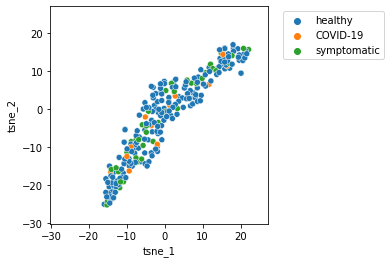

In [ ]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)